# **Gene Expression Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*DGE.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialGeneExpressionAnalysis.ipynb` notebook.

In [1]:

start_time <- Sys.time()
suppressWarnings({
    defaultW <- getOption("warn")  # suppress warnings for this cell
    options(warn = -1) 
    library(Biobase)
    library(pheatmap)
    library(snakecase)
    Sys.setenv(TAR = "/bin/tar") # for gzfile
    options(warn = defaultW)
})

Loading required package: BiocGenerics



Loading required package: parallel




Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min




Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




## 2. Making the matrices

### 2.1 Read in all the differential Gene Expression Analysis results

In [2]:
filenames <- list.files("../data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
message("Number of DGE files found with *_DGE.csv pattern: ",length(filenames))

Number of DGE files found with *_DGE.csv pattern: 39



### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [3]:
head(filenames,2)
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))

[1] "../data/adipose_subcutaneous_DGE.csv"    
[2] "../data/adipose_visceral_omentum_DGE.csv"


 0  1 
11 39 

Number of tissues with >=50 samples each in assets/tissues.tsv (tissue_reduction)39 5



### 2.3 Use the first file for the row order of the matrices

Arbitrarily using the first file, to obtain the ordered rownames for assignment to the remainder of the files in the construction of the matrix.

In [4]:
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
pVal_mat     <- logFC_mat
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 
pVal_mat_rownames  <- logFC_mat_rownames
pVal_mat     <- logFC_mat

In [5]:
head(logFC_mat,2)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,0.1565305,5.602619,3.795925,0.0001605512,0.001189525,-0.2420114
ENSG00000000005.5,0.2254314,4.050032,2.482310,0.0132994545,0.040295772,-4.1670662


### 2.4 create a matrix of the logFC values for each of the files

Read in the corrected GTEx expression object.  Get the gene names for this using the pData function for this expression object.

In [6]:
gtex.corrected<- readRDS(file = "../data/gtex.corrected.rds")

In [7]:
head(exprs(gtex.corrected),2)

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,1,1
ENSG00000227232.5,187,109,143,251,113,139,199,473,286,306,⋯,72,96,136,79,89,86,49,84,34,66


In [8]:
all.genes    <- rownames(exprs(gtex.corrected))
head(all.genes,2)
length(all.genes)
fc.exp.mat<-matrix(rep(0), length(all.genes)*length(filenames),nrow = length(all.genes),ncol=length(filenames))
dim(fc.exp.mat)

[1] "ENSG00000223972.5" "ENSG00000227232.5"

[1] 55878

[1] 55878    39

In [9]:
for (filename in filenames)
{
    next.res       <- read.csv(filename)
    
    next.res <- next.res[order(match(rownames(next.res),all.genes)),]
    
    rowmatch <- which(all.genes %in% rownames(next.res))
    
    colmatch <- which(filenames==filename)
    
    fc.exp.mat[c(rowmatch),colmatch]<-next.res$logFC[]
}

In [10]:
colnames(fc.exp.mat) <- gsub('../data/','',gsub('_DGE.csv','',filenames))

label.tab<-read.csv('../assets/tissues.tsv',header=TRUE,sep='\t')

label.tab<-label.tab[label.tab$name %in% colnames(fc.exp.mat),]

colnames(fc.exp.mat)<-label.tab$display.name[order(match(label.tab$display.name,colnames(fc.exp.mat)))]

In [11]:
tissue_list  <- levels(factor(tissue_reduction$SMTSD))
message("Number of tissues with at least 50 samples for both sexes: ",length(tissue_list))

Number of tissues with at least 50 samples for both sexes: 39



In [12]:
rs <- rowSums(fc.exp.mat)
max(rs)

[1] 25.41276

### 2.5 Calculate the correlation between the tissues using the logFC and render the heatmaps of the distance correlations

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   
Reduce the matrix to include only the non-zero results (necessary before calculating the distance.
Clustering by similar expression.  And display the heatmap.

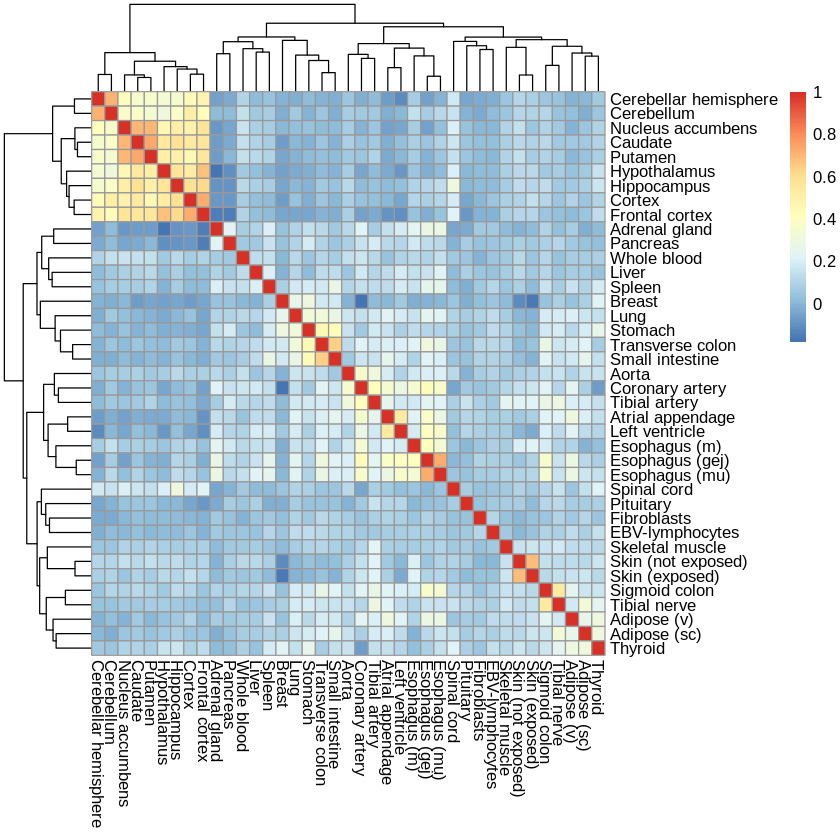

In [13]:
# dist_mat all values logFC_mat - reducing the 
fc.exp.mat<-fc.exp.mat[rowSums(fc.exp.mat!=0)>0,]
dist_mat <- as.matrix(cor(fc.exp.mat))
pheatmap(dist_mat)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/geneExpressionDistanceCorrelationHeatmapAlllogFC.pdf"))

## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [14]:
figure_id   = "expressionHeatmap"

### Appendix.2. Libraries

In [15]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../data/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../data/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../data/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../data/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../data/devtools_session_info.rds  ..



Done!




Saving `utils::sessionInfo()` objects in ../data/utils_session_info.rds  ..



Done!




 setting  value                       
 version  R version 4.1.0 (2021-05-18)
 os       Ubuntu 18.04.4 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2021-06-27                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.52.0,2.52.0,/opt/conda/envs/sbas/lib/R/library/Biobase,/opt/conda/envs/sbas/lib/R/library/Biobase,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
BiocGenerics,BiocGenerics,0.38.0,0.38.0,/opt/conda/envs/sbas/lib/R/library/BiocGenerics,/opt/conda/envs/sbas/lib/R/library/BiocGenerics,TRUE,FALSE,2021-05-19,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
pheatmap,pheatmap,1.0.12,1.0.12,/opt/conda/envs/sbas/lib/R/library/pheatmap,/opt/conda/envs/sbas/lib/R/library/pheatmap,TRUE,FALSE,2019-01-04,CRAN (R 4.1.0),NA,/opt/conda/envs/sbas/lib/R/library
snakecase,snakecase,0.11.0,0.11.0,/opt/conda/envs/sbas/lib/R/library/snakecase,/opt/conda/envs/sbas/lib/R/library/snakecase,TRUE,FALSE,2019-05-25,CRAN (R 4.1.0),NA,/opt/conda/envs/sbas/lib/R/library


In [16]:
end_time <- Sys.time()
end_time - start_time

Time difference of 1.144987 mins